# DRL Exercise 3: Meta and Transfer Learning



Authors: Jordan Conrad-Burton and Moshe Shem Tov

## Introduction

As we have seen in previous exercises, deep reinforcement learning algorithms usually require a large number of trials, and learning a new task entails recollecting a large dataset and training from scratch.

Intuitively, knowledge gained in learning one task should help in learning new, related tasks more quickly, similarly to how humans and animals work. In this assignment, we design reinforcement learning algorithms that do exactly that. These types of algorithms are called meta- or transfer-learning algorithms.

## Section 2: Fine-Tuning an Existing Model



In this section we will fine-tune a model trained on one problem and attempt to apply it to another. We will take the fully trained model and re-initialize the weights of the output layer and train the new network on the target environment.

We will do this for two different tasks (source -> target):

* Acrobot -> CartPole
* CartPole -> MountainCarContinuous

In [ ]:
!pip install gymnasium
!pip install torch torchvision

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import sklearn
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

In [ ]:
def get_action_space_size(env):
    if isinstance(env.action_space, gym.spaces.Box):
        return env.action_space.shape[0]
    else:
        return env.action_space.n

In [ ]:
def init_weights(layer, gain=1.0):
    if isinstance(layer, nn.Linear):
        torch.nn.init.orthogonal_(layer.weight, gain=gain)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

In [ ]:
def create_scaler(env, n_samples=10000):
    states = []
    for _ in range(n_samples):
        s = env.observation_space.sample()
        states.append(s)
    states = np.array(states)

    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(states)
    return scaler

In [ ]:
def scale_state(state, scaler):
    scaled = scaler.transform(state.reshape(1, -1))
    # return as 1D
    return scaled[0]

In [ ]:
def pad_state(state, max_input_size):
    padded_state = np.zeros(max_input_size)
    padded_state[: len(state)] = state

    return padded_state

In [ ]:
def mask_action(action_probs, act_space):
    masked_probs = action_probs.clone()
    masked_probs[act_space:] = 0
    masked_probs /= masked_probs.sum()

    return masked_probs

In [ ]:
def check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, target_average):
    rewards_last_100 = rewards_per_episode[-100:]
    rolling_avg = np.mean(rewards_last_100)
    rolling_avg_rewards.append(rolling_avg)

    if rolling_avg >= target_average:
        print(f"Agent reached optimal performance with an average reward of {target_average} over 100 episodes at episode {episode + 1}")

    return rolling_avg

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class PolicyNetworkContinuous(nn.Module):
    def __init__(self, input_size, output_size, hidden_size1=40, hidden_size2=40):
        super(PolicyNetworkContinuous, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ELU(),
            # nn.Linear(hidden_size1, hidden_size2),
            # nn.ELU(),
        )
        self.mu_layer = nn.Linear(hidden_size1, output_size)
        self.log_std = nn.Parameter(torch.zeros(output_size))

        self.apply(init_weights)

    def forward(self, x):
        x = self.fc(x)
        mu = self.mu_layer(x)
        log_std = self.log_std.clamp(-2, 1)
        std = torch.exp(log_std)
        return mu, std

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class ValueNetworkContinuous(nn.Module):
    def __init__(self, input_size, hidden_size1=400, hidden_size2=400):
        super(ValueNetworkContinuous, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ELU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ELU(),
            nn.Linear(hidden_size2, 1)
        )
        self.apply(init_weights)

    def forward(self, x):
        return self.fc(x)

In [ ]:
def reinit_layer(layer):
    if hasattr(layer, 'weight'):
        torch.nn.init.xavier_uniform_(layer.weight)
    if hasattr(layer, 'bias'):
        torch.nn.init.zeros_(layer.bias)

In [ ]:
def actor_critic(env, policy_network, value_network, policy_optimizer, value_optimizer, act_space_size, max_input_size,
                 num_episodes=1000, gamma=0.99, convergence_window=100, convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    policy_losses = []
    value_losses = []
    convergence = False

    start_time = time.time()

    for episode in range(num_episodes):
        state = env.reset()

        if isinstance(env.action_space, gym.spaces.Box):
            scaler = create_scaler(env)
            state = scale_state(state, scaler)

        total_reward = 0
        policy_episode_loss = 0.0
        value_episode_loss = 0.0

        done = False
        while not done:
            padded_state = pad_state(state, max_input_size)
            state_tensor = torch.tensor(padded_state, dtype=torch.float32)

            action_probs = policy_network(state_tensor)

            # continuous action space
            if isinstance(env.action_space, gym.spaces.Box):
                mu, std = action_probs
                action_dist = torch.distributions.Normal(mu, std)
                action = action_dist.sample()
                action = torch.clamp(action, min=-1.0, max=1.0)

                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.detach().numpy())
                next_state = scale_state(next_state, scaler)

            # discrete action space
            else:
                masked_probs = mask_action(action_probs, act_space_size)
                action_dist = torch.distributions.Categorical(masked_probs)
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                next_state, reward, done, _ = env.step(action.item())

            value = value_network(state_tensor)

            padded_next_state = pad_state(next_state, max_input_size)
            next_state_tensor = torch.tensor(padded_next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = (-log_prob * td_error.detach()).sum()  # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            policy_episode_loss += policy_loss.item()
            value_episode_loss += value_loss.item()

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards, optimal_performance_threshold)
        policy_losses.append(policy_episode_loss)
        value_losses.append(value_episode_loss)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total training time: {elapsed_time:.2f} seconds")

    return rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_network, value_network

In [ ]:
envs = {
    "CartPole-v1": gym.make("CartPole-v1"),
    "Acrobot-v1": gym.make("Acrobot-v1"),
    "MountainCarContinuous-v0": gym.make("MountainCarContinuous-v0")
}

env_targets = {
    "CartPole-v1": {"optimal": 475, "convergence": 195, "lr_p": 0.0002171250228971598, "lr_v": 0.0006, "gamma": 0.9915614564438548},
    "Acrobot-v1": {"optimal": -100, "convergence": -200, "lr_p": 0.0006403723092688441, "lr_v": 0.0008903908181162374, "gamma": 0.9936670420538545},
    "MountainCarContinuous-v0": {"optimal": 90, "convergence": 50, "lr_p": 3.7549879519576414e-05, "lr_v": 0.0005749550762716619, "gamma": 0.9971441494660566}
}

max_input_size = max(env.observation_space.shape[0] for env in envs.values())
max_output_size = max(env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n for env in envs.values())
print(max_input_size, max_output_size)

## Acrobot --> CartPole

In this section, we had little issue with training the agent on a discrete environment and then fine-tuning another discrete environment on top of it. The pretraining of the model on the Acrobot environment did help the model to learn faster with a total training time of 440 seconds, almost half of the previous training time on CartPole without the pretraining. In addition, on this run, the agent reached optimal performance before it reached convergence, indicating that it quickly was able to learn how to get the maximal rewards instead of slowly learning over time.

In [ ]:
env_name = "Acrobot-v1"
env = gym.make(env_name)

lr_p = env_targets[env_name]["lr_p"]
lr_v = env_targets[env_name]["lr_v"]
gamma = env_targets[env_name]["gamma"]

target_optimal = env_targets[env_name]["optimal"]
target_convergence = env_targets[env_name]["convergence"]
action_space_size = get_action_space_size(env)

if isinstance(env.action_space, gym.spaces.Box):
  policy_net = PolicyNetworkContinuous(max_input_size, max_output_size)
  value_net = ValueNetworkContinuous(max_input_size)
else:
  policy_net = PolicyNetwork(max_input_size, max_output_size)
  value_net = ValueNetwork(max_input_size)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net.parameters(), lr=lr_v)

print(f"Training on SOURCE {env_name}...")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_network, value_network = actor_critic(
    env, policy_net, value_net, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, num_episodes=2000, gamma=gamma, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

torch.save(policy_network.state_dict(), "policy_net_acrobot.pt")
torch.save(value_network.state_dict(),  "value_net_acrobot.pt")

In [ ]:
env_target_name = "CartPole-v1"
env_target = gym.make(env_target_name)

lr_p_target = env_targets[env_target_name]["lr_p"]
lr_v_target = env_targets[env_target_name]["lr_v"]
gamma_target = env_targets[env_target_name]["gamma"]

target_optimal_t = env_targets[env_target_name]["optimal"]
target_convergence_t = env_targets[env_target_name]["convergence"]
action_space_size_t = get_action_space_size(env_target)

policy_net_target = PolicyNetwork(max_input_size, max_output_size)
value_net_target  = ValueNetwork(max_input_size)

policy_net_target.load_state_dict(torch.load("policy_net_acrobot.pt"))
value_net_target.load_state_dict(torch.load("value_net_acrobot.pt"))

reinit_layer(policy_net_target.fc[-2])
reinit_layer(value_net_target.fc[-1])

In [ ]:
policy_optimizer_target = optim.Adam(policy_net_target.parameters(), lr=lr_p_target)
value_optimizer_target  = optim.Adam(value_net_target.parameters(),  lr=lr_v_target)

print(f"Fine-tuning on TARGET {env_target}...")
rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_net_target, value_net_target = actor_critic(
    env_target, policy_net_target, value_net_target, policy_optimizer_target, value_optimizer_target, action_space_size_t,
    max_input_size, num_episodes=2000, gamma=gamma_target, convergence_window=100,
    convergence_threshold=target_convergence_t, optimal_performance_threshold=target_optimal_t)

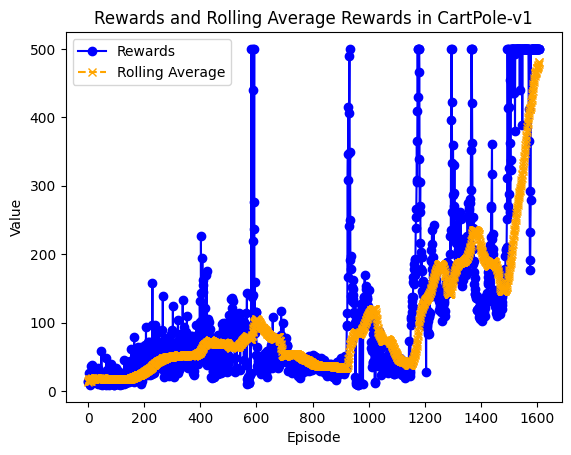

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title(f"Rewards and Rolling Average Rewards in {env_target_name}")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

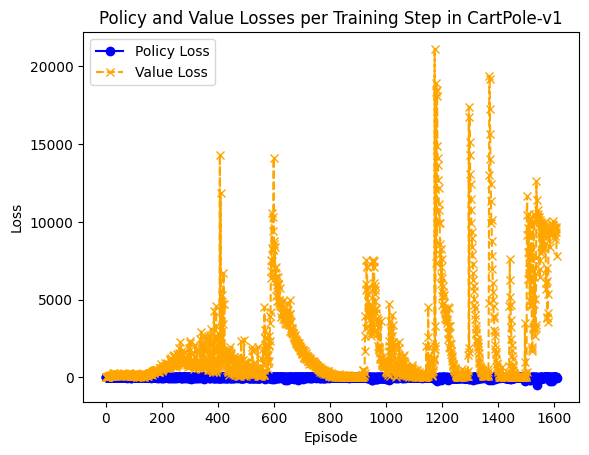

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(policy_losses, label="Policy Loss", color="blue", linestyle='-', marker='o')
plt.plot(value_losses, label="Value Loss", color="orange", linestyle='--', marker='x')
plt.title(f"Policy and Value Losses per Training Step in {env_target_name}")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

## CartPole --> MountainCar

This fine-tuning task was harder in that we needed to pretrain the model on a discrete environment and then fine-tune it on a continuous one. Because the outputs of the networks were different due to the nature of the environments, we used the same network structure as in the discrete case, but changed the final layers so that they would output the mean and standard deviation. We called this a “trunk-head” setup, where the internal layers were the same and shared between the discrete and continuous networks but the final layers could be changed.

First, we used the internal architecture of the original policy network we trained in the CartPole environment with one hidden layer of size 128. We trained this network in the CartPole environment until it reached convergence and optimal performance. We then copied the learned parameters into a new network that had a different output layer for the continuous environment. We then trained this network on the MountainCarContinuous environment.

In this case, the fine tuning did help the agent reach convergence at episode 266 and optimal performance at episode 234. It took a total of 465.75 seconds for the fine tuning training.


In [ ]:
class SharedTrunk(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(SharedTrunk, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        return x

In [ ]:
class ContinuousHeadPolicy(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(ContinuousHeadPolicy, self).__init__()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.ELU()

        self.mu = nn.Linear(hidden_size, output_size)
        self.log_std = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        x = self.activation(self.fc2(x))
        mu_val = self.mu(x)
        log_std_val = self.log_std.clamp(-2, 1)
        return mu_val, log_std_val

In [ ]:
class PolicyNetworkMountainCar(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super().__init__()
        self.trunk = SharedTrunk(input_size, hidden_size)
        self.continuous_head = ContinuousHeadPolicy(hidden_size, output_size)

    def forward(self, x):
        features = self.trunk(x)
        mu, log_std = self.continuous_head(features)
        std = torch.exp(log_std)
        return mu, std

In [ ]:
env_name = "CartPole-v1"
env = gym.make(env_name)

lr_p = env_targets[env_name]["lr_p"]
lr_v = env_targets[env_name]["lr_v"]
gamma = env_targets[env_name]["gamma"]

target_optimal = env_targets[env_name]["optimal"]
target_convergence = env_targets[env_name]["convergence"]
action_space_size = get_action_space_size(env)

if isinstance(env.action_space, gym.spaces.Box):
  policy_net = PolicyNetworkContinuous(max_input_size, max_output_size)
  value_net = ValueNetworkContinuous(max_input_size)
else:
  policy_net = PolicyNetwork(max_input_size, max_output_size)
  value_net = ValueNetwork(max_input_size)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=lr_p)
value_optimizer = optim.Adam(value_net.parameters(), lr=lr_v)

print(f"Training on SOURCE {env_name}...")

rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_network, value_network = actor_critic(
    env, policy_net, value_net, policy_optimizer, value_optimizer, action_space_size,
    max_input_size, num_episodes=2000, gamma=gamma, convergence_window=100,
    convergence_threshold=target_convergence, optimal_performance_threshold=target_optimal)

torch.save(policy_network.state_dict(), "policy_net_cartpole.pt")
torch.save(value_network.state_dict(),  "value_net_cartpole.pt")

In [ ]:
source_dict = torch.load("policy_net_cartpole.pt")
renamed_dict = {}

for old_key, param in source_dict.items():
    # e.g. "fc.0.weight" should become "trunk.fc1.weight"
    #      "fc.0.bias"   -> "trunk.fc1.bias"
    #      "fc.2.weight" -> "trunk.fc2.weight"
    #      "fc.2.bias"   -> "trunk.fc2.bias"

    if old_key == "fc.0.weight":
        new_key = "trunk.fc1.weight"
    elif old_key == "fc.0.bias":
        new_key = "trunk.fc1.bias"
    elif old_key == "fc.2.weight":
        new_key = "trunk.fc2.weight"
    elif old_key == "fc.2.bias":
        new_key = "trunk.fc2.bias"
    else:
        continue

    renamed_dict[new_key] = param

In [ ]:
env_target_name = "MountainCarContinuous-v0"
env_target = gym.make(env_target_name)

lr_p_target = env_targets[env_target_name]["lr_p"]
lr_v_target = env_targets[env_target_name]["lr_v"]
gamma_target = env_targets[env_target_name]["gamma"]

target_optimal_t = env_targets[env_target_name]["optimal"]
target_convergence_t = env_targets[env_target_name]["convergence"]
action_space_size_t = get_action_space_size(env_target)

policy_net_target = PolicyNetworkMountainCar(max_input_size, max_output_size)
value_net_target = ValueNetwork(max_input_size)

policy_net_target.load_state_dict(renamed_dict, strict=False)
value_net_target.load_state_dict(torch.load("value_net_cartpole.pt"))

value_net_target.fc[-1] = nn.Linear(128, 1)

policy_net_target.mu_layer = nn.Linear(128, max_output_size)
torch.nn.init.xavier_uniform_(policy_net_target.mu_layer.weight)
torch.nn.init.zeros_(policy_net_target.mu_layer.bias)
policy_net_target.log_std = nn.Parameter(torch.zeros(1))

In [ ]:
policy_optimizer_target = optim.Adam(policy_net_target.parameters(), lr=lr_p_target)
value_optimizer_target  = optim.Adam(value_net_target.parameters(),  lr=lr_v_target)

print(f"Fine-tuning on TARGET {env_target}...")
rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards, policy_net_target, value_net_target = actor_critic(
    env_target, policy_net_target, value_net_target, policy_optimizer_target, value_optimizer_target, action_space_size_t,
    max_input_size, num_episodes=2000, gamma=gamma_target, convergence_window=100,
    convergence_threshold=target_convergence_t, optimal_performance_threshold=target_optimal_t)

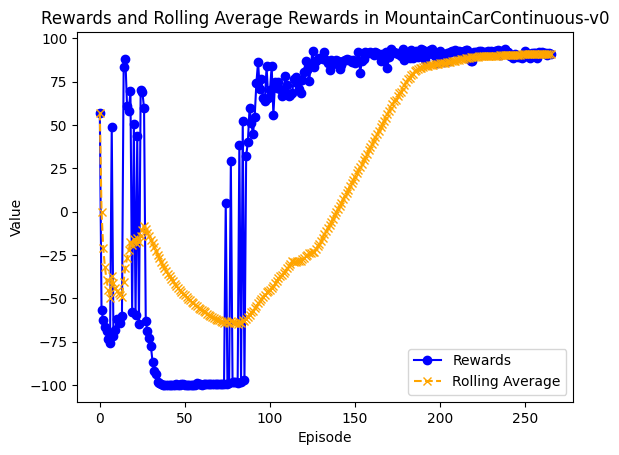

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title(f"Rewards and Rolling Average Rewards in {env_target_name}")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

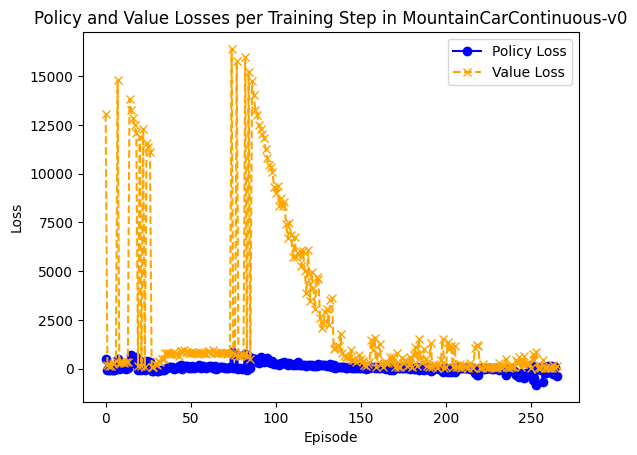

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(policy_losses, label="Policy Loss", color="blue", linestyle='-', marker='o')
plt.plot(value_losses, label="Value Loss", color="orange", linestyle='--', marker='x')
plt.title(f"Policy and Value Losses per Training Step in {env_target_name}")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Discussion

We saw that in both cases, the pretraining of the network on a different environment (Acrobot or CartPole) actually helped the agent learn and perform better in the second environment when doing the fine tuning. In the Acrobot → CartPole fine-tuning, the results were pretty straight forward. There was no need to adapt the policy network since both environments were discrete, therefore the same exact network was used in both environments. Pretraining on the Acrobot environment took 391 episodes with a total training time of 152.58 seconds. The fine tuning on the CartPole environment then took an additional 440 seconds, bringing the total training time to 592 seconds, still less than the total training time for CartPole in part 1 without the pretraining. Basically, the pretraining worked!

In the second case, CartPole → MountainCarContinuous, the outputs of the policy network had to be adapted slightly since in a continuous environment, we sample from a distribution with the output of the network being the mean and standard deviation instead of the possible actions in a discrete environment. To do this, we adopted a “trunk-head” approach where both policy networks would share their internal structure but the outer layer would be slightly different in order to produce the required results, especially since in a discrete case, the last layer is fed through a softmax, something that is not necessary in the continuous case.

We pretrained the network on CartPole until it reached convergence and optimal performance. In this case that was 836.48 seconds and 1691 episodes. We then trained the network on the MountainCarContinuous environment which then reached convergence and optimal performance at 266 episodes and 465 seconds. While this process had a training time that was longer than the training time of MountainCarContinuous by itself with no pretraining, the policy and value networks used are different. For example, the value network used by CartPole for the pretraining and then MountainCarContinuous for the fine-tuning had one layer with 128 neurons and used the ReLU activation function. Whereas in the original MountainCarContinuous run, we changed the architecture of the value network to have two hidden layers each of size 400, use the ELU activation function, and even have an orthogonal weight initialization. All of these changes were because the agent had a difficult time learning the MountainCarContinuous environment with the original architecture used successfully by the other two environments. So, while the pretraining and fine-tuning of CartPole → MountainCarContinuous did take longer than the simple training of MountainCarContinuous with a much different architecture, it was able to reach convergence and optimal performance with the original architecture when it couldn’t previously.
